# Applied Data Science Capstone

## Week 4 & 5 - The Battle of the Neighborhoods

### So you want to start a bakery in NY? 

#### Introduction/Business Problem

In this final project a bakery franchise has contacted me with the intention of setting up a bakery in New York. By using data from various sources the mission is to assist in location the best location with emphasize on underserved areas. 

#### Data
To find the solution to the above problem i will use data from https://cocl.us/new_york_dataset for boroughs, neighborhoods and latitude and longitude data for New York. Also data from https://en.wikipedia.org/wiki/Boroughs_of_New_York_City to find capita per neighborhood and capita density per sq km.
Data from Foursquare will be used to find locations and ratings of Bakeries.

In [1]:
#Install and import required libraries 
import lxml.html as lh
import requests
import pandas as pd
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os

In [2]:
CLIENT_ID = '3K2KV2LB4YF5IYQCFYKP0PNK4MYM5GSRFHFST43GFYXYD2XK' # your Foursquare ID
CLIENT_SECRET = 'WARYNNTOW2C1C5BL2BHPRIUN3CIOQX4JYHHKHHIZXOA3KY3J' # your Foursquare Secret
ACCESS_TOKEN = 'C3CN3EHMDQ4BPYNWUZBYSXOVFTC24FJ0EOGB4CCNVYSNIC2K' # your FourSquare Access Token
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3K2KV2LB4YF5IYQCFYKP0PNK4MYM5GSRFHFST43GFYXYD2XK
CLIENT_SECRET:WARYNNTOW2C1C5BL2BHPRIUN3CIOQX4JYHHKHHIZXOA3KY3J


In [34]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [35]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [36]:
ny_data.shape

(306, 4)

In [37]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
bakeries_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    bakeries=venues[venues['Category']=='Bakery']   
    print('(',count,'/',len(ny_data),')','Bakeries in '+Neighborhood+', '+Borough+':'+str(len(bakeries)))
    print(row)
    for bakery_detail in bakeries.values.tolist():
        id, name , category=bakery_detail
        bakeries_ny = bakeries_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Bakeries in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Bakeries in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Bakeries in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Bakeries in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Bakeries in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Bakeries in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Bakeries in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Bakeries in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Bakeries in Norwood, Bronx:0
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
( 10 / 306 ) Bakeries in Williamsbridge, B

( 74 / 306 ) Bakeries in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]


KeyError: 'groups'

In [ ]:
bakeries_ny.to_csv('bakeries_ny.csv') # Save the to CSV to limit API calls

In [38]:
bakeries_ny = pd.read_csv('bakeries_ny.csv')
bakeries_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
151,151,Brooklyn,Fulton Ferry,43504680f964a520b0281fe3,Almondine Bakery
152,152,Brooklyn,Dumbo,52b204c0498efe3c3be32d91,Burrow
153,153,Brooklyn,Dumbo,43504680f964a520b0281fe3,Almondine Bakery
154,154,Brooklyn,Dumbo,4f21bb85e5e872143c0ca04b,One Girl Cookies
155,155,Brooklyn,Homecrest,4c9e27ea54c8a1cdabb68a4b,Ka Ka Bakery


In [39]:
bakeries_ny = bakeries_ny.drop(['Unnamed: 0'], axis=1)

In [40]:
bakeries_ny.shape

(156, 4)

### Analyzing data
We can see Manhattan has the most bakeries of the boroughs in NY (fig 1). Next we can see number of persons per square km per borough (fig 2). By combining these two datasets we can find the most underserved borough as rate of bakeries per 1000 persons(fig 3) is the Bronx.
In fig 4 we can see that the neighborhood with the most bakeries are Little Italy followed by Chinatown, both located in Manhattan.

In [41]:
#Capita per sq km in NYC. Data from https://en.wikipedia.org/wiki/Boroughs_of_New_York_City
# Since the data size is so small i have just created a manual dict and dataframe
ny_bor_cap = {'Borough': ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], 'per_per_km2': [13006, 13957, 27544, 8018, 3150]}
cap_df = pd.DataFrame(data=ny_bor_cap)
cap_df

,Borough,per_per_km2
0,Bronx,13006
1,Brooklyn,13957
2,Manhattan,27544
3,Queens,8018
4,Staten Island,3150


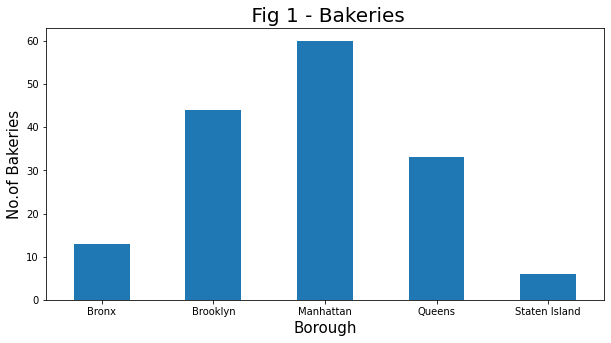

In [42]:
# Bakeries per borough
bakeries_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title(' Fig 1 - Bakeries', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Bakeries', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

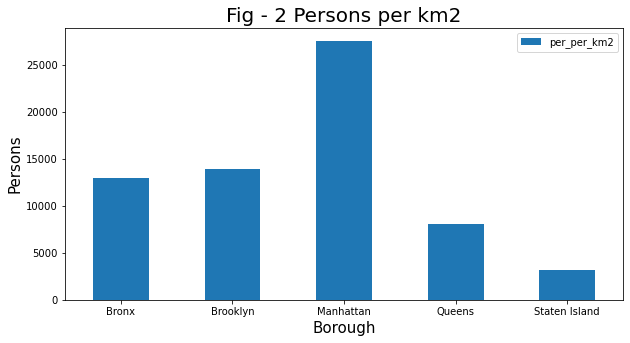

In [43]:
#Capita density
cap_df.plot.bar(x='Borough', figsize=(10,5))
plt.title('Fig - 2 Persons per km2', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Persons', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [44]:
comparison_series = bakeries_ny.groupby('Borough')['ID'].count()
comp_df = comparison_series.to_frame()
comp_df = comp_df.rename(columns = {'ID': 'nbr_bakeries'})
comp_df

,nbr_bakeries
Borough,
Bronx,13
Brooklyn,44
Manhattan,60
Queens,33
Staten Island,6


In [45]:
comp_df = pd.merge(comp_df, cap_df, on='Borough')
comp_df['bakeries_per_1000'] = comp_df['nbr_bakeries']/ comp_df['per_per_km2'] * 1000
comp_df = comp_df.drop(columns=['nbr_bakeries', 'per_per_km2'], axis=1)

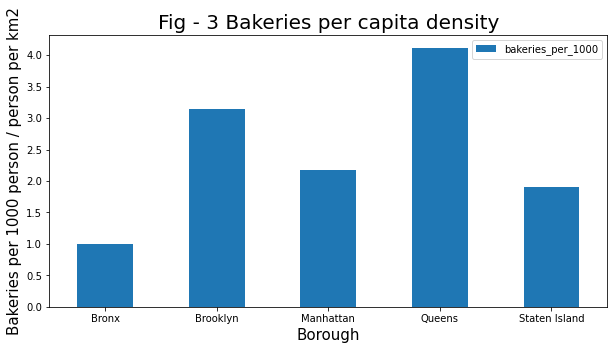

In [46]:
comp_df.plot.bar(x='Borough', figsize=(10,5))
plt.title('Fig - 3 Bakeries per capita density', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Bakeries per 1000 person / person per km2', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

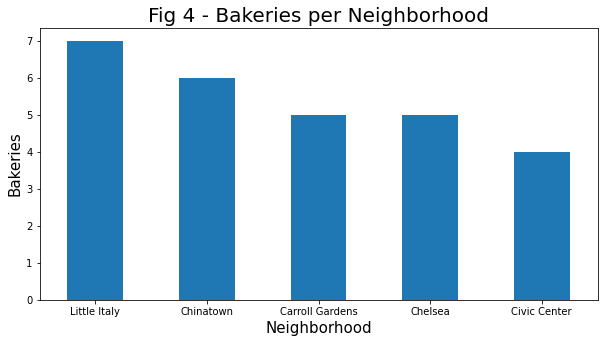

In [47]:
#Most bakeries per neighborhood
NOofNeigh = 5 # top number for graphing all the same past 6
bakeries_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5))
plt.title('Fig 4 - Bakeries per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Bakeries', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [48]:
bakeries_ny[bakeries_ny['Neighborhood']=='Little Italy']

,Borough,Neighborhood,ID,Name
84,Manhattan,Little Italy,3fd66200f964a520bce61ee3,La Bella Ferrara
85,Manhattan,Little Italy,49ee25b6f964a5202b681fe3,Eileen's Special Cheesecake
86,Manhattan,Little Italy,4d03ae3437036dcbfba10bfb,Ferrara Bakery
87,Manhattan,Little Italy,4c66e494f7a80f47d85f9f7a,Manna House Bakery
88,Manhattan,Little Italy,4b574522f964a520742e28e3,Double Crispy Bakery Inc
89,Manhattan,Little Italy,53ecfe56498e8ee1b1cabc2a,Go Believe Bakery
90,Manhattan,Little Italy,4abe5120f964a520a08c20e3,Golden Steamer


In [49]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
bakeries_stats=pd.DataFrame(columns=column_names)
count=1
for row in bakeries_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(bakeries_ny),')','processed')
    bakeries_stats = bakeries_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
bakeries_stats.tail()

{'meta': {'code': 200, 'requestId': '608aa011f365de054713972a'}, 'response': {'venue': {'id': '4dab094ccda1652a2b99c1c9', 'name': "Ana's Bakery & Cafe", 'contact': {}, 'location': {'address': '2125 Williamsbridge Rd', 'lat': 40.856021881103516, 'lng': -73.85604858398438, 'labeledLatLngs': [{'label': 'display', 'lat': 40.856021881103516, 'lng': -73.85604858398438}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2125 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/anas-bakery--cafe/4dab094ccda1652a2b99c1c9', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 0, 'groups': 

{'meta': {'code': 200, 'requestId': '608aa012c835ba3893532333'}, 'response': {'venue': {'id': '51a3c054498e210b7bf17b93', 'name': 'Baskin Robbins Bronx', 'contact': {}, 'location': {'lat': 40.859725301922786, 'lng': -73.89726689544588, 'labeledLatLngs': [{'label': 'display', 'lat': 40.859725301922786, 'lng': -73.89726689544588}], 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Bronx, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baskin-robbins-bronx/51a3c054498e210b7bf17b93', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c9941735', 'name': 'Ice Cream Shop', 'pluralName': 'Ice Cream Shops', 'shortName': 'Ice Cream', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_', 'suffix': '.png'}}], 'verifie

{'meta': {'code': 200, 'requestId': '608aa013b9f8407d907aac45'}, 'response': {'venue': {'id': '4e31884ad4c0b2aebf7177ff', 'name': 'Ronald Pitusa Bakery', 'contact': {'phone': '7188286917', 'formattedPhone': '(718) 828-6917'}, 'location': {'address': '1812 White Plains Rd', 'crossStreet': 'Morris Park', 'lat': 40.845733, 'lng': -73.865935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.845733, 'lng': -73.865935}, {'label': 'entrance', 'lat': 40.845718, 'lng': -73.866112}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1812 White Plains Rd (Morris Park)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ronald-pitusa-bakery/4e31884ad4c0b2aebf7177ff', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified

{'meta': {'code': 200, 'requestId': '608aa0135599cf208c0884ab'}, 'response': {'venue': {'id': '4af1a473f964a520c5e121e3', 'name': 'Egidio Pastry Shop', 'contact': {'phone': '7182956077', 'formattedPhone': '(718) 295-6077'}, 'location': {'address': '622 E 187th St', 'crossStreet': 'at Hughes Ave', 'lat': 40.85514224140267, 'lng': -73.88697184841936, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85514224140267, 'lng': -73.88697184841936}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['622 E 187th St (at Hughes Ave)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/egidio-pastry-shop/4af1a473f964a520c5e121e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 17}, 'ur

{'meta': {'code': 200, 'requestId': '608aa014a74b43585dc4a933'}, 'response': {'venue': {'id': '4bb6496e46d4a59398fdc5c0', 'name': 'Madonia Bakery', 'contact': {'phone': '7182955573', 'formattedPhone': '(718) 295-5573', 'facebook': '144014352297189', 'facebookName': 'Madonia Brothers Bakery'}, 'location': {'address': '2348 Arthur Ave', 'lat': 40.85441232476012, 'lng': -73.88851590024353, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85441232476012, 'lng': -73.88851590024353}, {'label': 'entrance', 'lat': 40.854404, 'lng': -73.888396}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2348 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/madonia-bakery/4bb6496e46d4a59398fdc5c0', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix

{'meta': {'code': 200, 'requestId': '608aa014ec12d2422ae8da79'}, 'response': {'venue': {'id': '4b366de6f964a5202d3525e3', 'name': 'Addeo & Sons Bakery', 'contact': {'phone': '7183678316', 'formattedPhone': '(718) 367-8316'}, 'location': {'address': '2372 Hughes Ave', 'crossStreet': 'E186th', 'lat': 40.85449717034133, 'lng': -73.88759144753934, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85449717034133, 'lng': -73.88759144753934}, {'label': 'entrance', 'lat': 40.854474, 'lng': -73.887238}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2372 Hughes Ave (E186th)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/addeo--sons-bakery/4b366de6f964a5202d3525e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '608aa01504ef220d87b1d33b'}, 'response': {'venue': {'id': '4c9205941adc370460a134d1', 'name': 'Zeppieri & Sons Italian Bakery', 'contact': {'phone': '7188299111', 'formattedPhone': '(718) 829-9111', 'facebook': '216817995054099', 'facebookUsername': 'zeppieriandsons', 'facebookName': 'Zeppieri & Sons Italian Bakery'}, 'location': {'address': '3004 Buhre Ave', 'crossStreet': 'Crosby Avenue', 'lat': 40.847119272159645, 'lng': -73.83205709805584, 'labeledLatLngs': [{'label': 'display', 'lat': 40.847119272159645, 'lng': -73.83205709805584}, {'label': 'entrance', 'lat': 40.84704, 'lng': -73.831844}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3004 Buhre Ave (Crosby Avenue)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zeppieri--sons-italian-bakery/4c9205941adc370460a134d1', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'plura

{'meta': {'code': 200, 'requestId': '608aa0159823e3790ef93760'}, 'response': {'venue': {'id': '4c9bb31e9975a1438f922bcf', 'name': 'Marinells Bakery', 'contact': {'phone': '7185883585', 'formattedPhone': '(718) 588-3585'}, 'location': {'address': '264 E 167th St', 'crossStreet': 'btwn Morris & Grant Ave.', 'lat': 40.83336858139031, 'lng': -73.91445285669495, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83336858139031, 'lng': -73.91445285669495}, {'label': 'entrance', 'lat': 40.833287, 'lng': -73.914443}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['264 E 167th St (btwn Morris & Grant Ave.)', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marinells-bakery/4c9bb31e9975a1438f922bcf', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix':

{'meta': {'code': 200, 'requestId': '608aa016ae879258d1bd5c9c'}, 'response': {'venue': {'id': '4b8d36cbf964a520bbed32e3', 'name': 'Don Paco Lopez Panaderia', 'contact': {'phone': '7184927443', 'formattedPhone': '(718) 492-7443'}, 'location': {'address': '4703 4th Ave', 'lat': 40.648016864662765, 'lng': -74.01084252540383, 'labeledLatLngs': [{'label': 'display', 'lat': 40.648016864662765, 'lng': -74.01084252540383}, {'label': 'entrance', 'lat': 40.6479, 'lng': -74.010796}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4703 4th Ave', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/don-paco-lopez-panaderia/4b8d36cbf964a520bbed32e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'sta

{'meta': {'code': 200, 'requestId': '608aa0179b08b257da4fcd16'}, 'response': {'venue': {'id': '4da602dacda1b0253fe9192e', 'name': 'Nuccios Bakery', 'contact': {'phone': '7184493035', 'formattedPhone': '(718) 449-3035'}, 'location': {'address': '261 Avenue U', 'lat': 40.597097, 'lng': -73.97448299999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.597097, 'lng': -73.97448299999999}, {'label': 'entrance', 'lat': 40.596941, 'lng': -73.974505}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Avenue U', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nuccios-bakery/4da602dacda1b0253fe9192e', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tie

{'meta': {'code': 200, 'requestId': '608aa0189823e3790ef93d69'}, 'response': {'venue': {'id': '4b50addbf964a520132d27e3', 'name': "Gombo's Bakery", 'contact': {'phone': '7187717701', 'formattedPhone': '(718) 771-7701'}, 'location': {'address': '328 Kingston Ave', 'crossStreet': 'President', 'lat': 40.66805347569283, 'lng': -73.94243991715994, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66805347569283, 'lng': -73.94243991715994}, {'label': 'entrance', 'lat': 40.667882, 'lng': -73.942467}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Kingston Ave (President)', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gombos-bakery/4b50addbf964a520132d27e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '608aa019a347121a79dc8fd5'}, 'response': {'venue': {'id': '4ac787f5f964a520c9b720e3', 'name': 'Regina Bakery Inc.', 'contact': {'phone': '7187882448', 'formattedPhone': '(718) 788-2448'}, 'location': {'address': '485 Prospect Ave', 'crossStreet': 'btw Prospect Park W & 8th Ave', 'lat': 40.65886137286639, 'lng': -73.98188883892442, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65886137286639, 'lng': -73.98188883892442}, {'label': 'entrance', 'lat': 40.659049, 'lng': -73.981877}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['485 Prospect Ave (btw Prospect Park W & 8th Ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/regina-bakery-inc/4ac787f5f964a520c9b720e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '608aa019ae879258d1bd64b4'}, 'response': {'venue': {'id': '4a9e748df964a5203a3a20e3', 'name': "Little Miss Muffin 'n' Her Stuffin'", 'contact': {'phone': '7188574963', 'formattedPhone': '(718) 857-4963'}, 'location': {'address': '768 Washington Ave', 'crossStreet': 'Park Pl', 'lat': 40.67507145714611, 'lng': -73.96326024319478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67507145714611, 'lng': -73.96326024319478}, {'label': 'entrance', 'lat': 40.675062, 'lng': -73.963388}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['768 Washington Ave (Park Pl)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-miss-muffin-n-her-stuffin/4a9e748df964a5203a3a20e3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bake

{'meta': {'code': 200, 'requestId': '608aa01a495a957181b9bf6c'}, 'response': {'venue': {'id': '548eeada498e4c3cf0acd057', 'name': 'Little Cupcake Bakeshop', 'contact': {'phone': '7187830770', 'formattedPhone': '(718) 783-0770'}, 'location': {'address': '598 Vanderbilt Ave', 'lat': 40.67846761615478, 'lng': -73.9686844966458, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67846761615478, 'lng': -73.9686844966458}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['598 Vanderbilt Ave', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-cupcake-bakeshop/548eeada498e4c3cf0acd057', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 31}, 'url': 'http://littlecupcakeb

{'meta': {'code': 200, 'requestId': '608aa01a92898d4d0789859b'}, 'response': {'venue': {'id': '5e3edebe15fcac000794f44b', 'name': 'Mille-Feuille', 'contact': {}, 'location': {'address': '620 Vanderbilt Ave', 'crossStreet': 'at Prospect Pl', 'lat': 40.677582, 'lng': -73.969112, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677582, 'lng': -73.969112}], 'postalCode': '11238', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['620 Vanderbilt Ave (at Prospect Pl)', 'New York, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/millefeuille/5e3edebe15fcac000794f44b', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.ne

{'meta': {'code': 200, 'requestId': '608aa01a723e091241f725ef'}, 'response': {'venue': {'id': '54bac253498e94c7a5201b01', 'name': 'Bushwick Bakery', 'contact': {'twitter': 'bushwick_bakery', 'instagram': 'bushwickbakery', 'facebook': '453720244752594', 'facebookUsername': '127central', 'facebookName': 'Bushwick Bakery'}, 'location': {'address': '127 Central Ave', 'crossStreet': 'at Starr St', 'lat': 40.69997562236325, 'lng': -73.92798179210126, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69997562236325, 'lng': -73.92798179210126}, {'label': 'entrance', 'lat': 40.699869, 'lng': -73.928084}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['127 Central Ave (at Starr St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bushwick-bakery/54bac253498e94c7a5201b01', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', '

{'meta': {'code': 200, 'requestId': '608aa01bec12d2422ae8eaff'}, 'response': {'venue': {'id': '5d2d05d72f61e8002384c3a7', 'name': 'Amy’s Bread', 'contact': {}, 'location': {'address': '74 Clark Street', 'lat': 40.697393, 'lng': -73.993593, 'labeledLatLngs': [{'label': 'display', 'lat': 40.697393, 'lng': -73.993593}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['74 Clark Street', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/amys-bread/5d2d05d72f61e8002384c3a7', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'type': 'others', 'count': 1, 'items': [{'firstName': '

{'meta': {'code': 200, 'requestId': '608aa01bb7c8722660cbe220'}, 'response': {'venue': {'id': '4a69cfeaf964a52015cc1fe3', 'name': "Monteleone's Bakery", 'contact': {'phone': '7188525600', 'formattedPhone': '(718) 852-5600', 'facebook': '533813626632960', 'facebookUsername': 'FMonteleoneBakery', 'facebookName': 'F. Monteleone Bakery'}, 'location': {'address': '355 Court St', 'crossStreet': 'btwn Union & President St', 'lat': 40.68194002100747, 'lng': -73.99609790259039, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68194002100747, 'lng': -73.99609790259039}, {'label': 'entrance', 'lat': 40.681959, 'lng': -73.995956}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['355 Court St (btwn Union & President St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/monteleones-bakery/4a69cfeaf964a52015cc1fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName

{'meta': {'code': 200, 'requestId': '608aa01c0fe253665ec59dd8'}, 'response': {'venue': {'id': '5e409ad541d83000084df5b8', 'name': 'Le French Tart Deli', 'contact': {}, 'location': {'address': '306 Court St', 'crossStreet': 'Degraw Street', 'lat': 40.683677, 'lng': -73.995328, 'labeledLatLngs': [{'label': 'display', 'lat': 40.683677, 'lng': -73.995328}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['306 Court St (Degraw Street)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/le-french-tart-deli/5e409ad541d83000084df5b8', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10c941735', 'name': 'French Restaurant', 'pluralName': 'French Restaurants', 'shortName': 'French', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '608aa01c9e77ac7926e46be0'}, 'response': {'venue': {'id': '3fd66200f964a52075eb1ee3', 'name': 'Caputo Bakery', 'contact': {'phone': '7188756871', 'formattedPhone': '(718) 875-6871'}, 'location': {'address': '329 Court St', 'crossStreet': 'btwn Sackett & Union St', 'lat': 40.682972506411595, 'lng': -73.99559695307425, 'labeledLatLngs': [{'label': 'display', 'lat': 40.682972506411595, 'lng': -73.99559695307425}, {'label': 'entrance', 'lat': 40.682856, 'lng': -73.995514}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['329 Court St (btwn Sackett & Union St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caputo-bakery/3fd66200f964a52075eb1ee3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.p

{'meta': {'code': 200, 'requestId': '608aa01d512b0e2732f0e550'}, 'response': {'venue': {'id': '4a0db3fdf964a52090751fe3', 'name': 'Brooklyn Bread Cafe', 'contact': {'phone': '9292502715', 'formattedPhone': '(929) 250-2715', 'facebook': '102228989820734', 'facebookUsername': 'brooklynbreadcafe', 'facebookName': 'Brooklyn Bread Cafe'}, 'location': {'address': '412 Court St', 'crossStreet': '2nd Place', 'lat': 40.680118, 'lng': -73.997161, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680118, 'lng': -73.997161}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['412 Court St (2nd Place)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/brooklyn-bread-cafe/4a0db3fdf964a52090751fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '608aa01eec12d2422ae8f2b6'}, 'response': {'venue': {'id': '44dc6750f964a520a6361fe3', 'name': 'Baked', 'contact': {'phone': '7182220345', 'formattedPhone': '(718) 222-0345', 'twitter': 'brooklynbaker', 'instagram': 'bakednyc'}, 'location': {'address': '359 Van Brunt St', 'crossStreet': 'at Dikeman St', 'lat': 40.67695855746999, 'lng': -74.01332712873493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67695855746999, 'lng': -74.01332712873493}, {'label': 'entrance', 'lat': 40.676869, 'lng': -74.013296}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['359 Van Brunt St (at Dikeman St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baked/44dc6750f964a520a6361fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '608aa01e87f6d50764cb8553'}, 'response': {'venue': {'id': '4b7d51f3f964a52013b82fe3', 'name': "Cousin John's Cafe and Bakery", 'contact': {'phone': '7186227333', 'formattedPhone': '(718) 622-7333'}, 'location': {'address': '70 7th Ave', 'crossStreet': 'btwn Lincoln & Berkeley Pl', 'lat': 40.67535345399024, 'lng': -73.97495903554368, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67535345399024, 'lng': -73.97495903554368}, {'label': 'entrance', 'lat': 40.675395, 'lng': -73.974976}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['70 7th Ave (btwn Lincoln & Berkeley Pl)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cousin-johns-cafe-and-bakery/4b7d51f3f964a52013b82fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_

{'meta': {'code': 200, 'requestId': '608aa01eff75cb354cca56e5'}, 'response': {'venue': {'id': '595183c718d43b1841112628', 'name': 'Dulcinea Churros & Co.', 'contact': {}, 'location': {'address': '445 Albee Sq W', 'lat': 40.691364121289034, 'lng': -73.98242090218575, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691364121289034, 'lng': -73.98242090218575}], 'postalCode': '11201', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq W', 'New York, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dulcinea-churros--co/595183c718d43b1841112628', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 19, 'groups': [{'

{'meta': {'code': 200, 'requestId': '608aa01f663a6f307f2d34ab'}, 'response': {'venue': {'id': '4a14b462f964a5206a781fe3', 'name': 'Betty Bakery', 'contact': {'phone': '7182462402', 'formattedPhone': '(718) 246-2402', 'twitter': 'bettybakery'}, 'location': {'address': '448 Atlantic Ave', 'crossStreet': 'btwn Bond & Nevins', 'lat': 40.6863845552732, 'lng': -73.98335021420114, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6863845552732, 'lng': -73.98335021420114}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['448 Atlantic Ave (btwn Bond & Nevins)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/betty-bakery/4a14b462f964a5206a781fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4

{'meta': {'code': 200, 'requestId': '608aa01f067be71063daaaa0'}, 'response': {'venue': {'id': '4dc20c4cb0fb490416a7af8e', 'name': 'Tower Isle Patties', 'contact': {'phone': '7184952626', 'formattedPhone': '(718) 495-2626'}, 'location': {'address': '2025 Atlantic Ave', 'crossStreet': 'Thomas S Boyland St', 'lat': 40.67530979932838, 'lng': -73.91315575832215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67530979932838, 'lng': -73.91315575832215}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2025 Atlantic Ave (Thomas S Boyland St)', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tower-isle-patties/4dc20c4cb0fb490416a7af8e', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats

{'meta': {'code': 200, 'requestId': '608aa020a347121a79dca26a'}, 'response': {'venue': {'id': '4f32625119836c91c7d28149', 'name': 'Los Rey Bakery', 'contact': {'phone': '7183489201', 'formattedPhone': '(718) 348-9201'}, 'location': {'address': '1084 Liberty Ave', 'lat': 40.678164, 'lng': -73.869293, 'labeledLatLngs': [{'label': 'display', 'lat': 40.678164, 'lng': -73.869293}, {'label': 'entrance', 'lat': 40.678295, 'lng': -73.869325}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1084 Liberty Ave', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/los-rey-bakery/4f32625119836c91c7d28149', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, '

{'meta': {'code': 200, 'requestId': '608aa021ec12d2422ae8fad3'}, 'response': {'venue': {'id': '4a5f65cef964a52081bf1fe3', 'name': 'Stella di Sicilia Bakery', 'contact': {'phone': '7184171849', 'formattedPhone': '(718) 417-1849'}, 'location': {'address': '217 Montrose Ave', 'crossStreet': 'btw Bushwick Ave & Humboldt St', 'lat': 40.70765814420951, 'lng': -73.9402181654083, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70765814420951, 'lng': -73.9402181654083}, {'label': 'entrance', 'lat': 40.707719, 'lng': -73.940328}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['217 Montrose Ave (btw Bushwick Ave & Humboldt St)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/stella-di-sicilia-bakery/4a5f65cef964a52081bf1fe3', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '608aa02189acb8249a48ff77'}, 'response': {'venue': {'id': '56b89eb438fa514c68e8a175', 'name': 'Luckybird Bakery', 'contact': {'instagram': 'luckybirdbakes'}, 'location': {'address': '163 Montrose Ave', 'crossStreet': 'btwn Graham Ave & Humboldt St', 'lat': 40.70750668361995, 'lng': -73.94267410039902, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70750668361995, 'lng': -73.94267410039902}, {'label': 'entrance', 'lat': 40.707494, 'lng': -73.942678}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['163 Montrose Ave (btwn Graham Ave & Humboldt St)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/luckybird-bakery/56b89eb438fa514c68e8a175', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '608aa0223a2ecf5737939dca'}, 'response': {'venue': {'id': '5d62af746d30980007d08784', 'name': 'Win Son Bakery', 'contact': {'phone': '9179091725', 'formattedPhone': '(917) 909-1725', 'instagram': 'winsonbakery'}, 'location': {'address': '164 Graham Ave', 'crossStreet': 'at Montrose Ave', 'lat': 40.70722609513913, 'lng': -73.94298523664474, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70722609513913, 'lng': -73.94298523664474}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['164 Graham Ave (at Montrose Ave)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/win-son-bakery/5d62af746d30980007d08784', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3b813cf

{'meta': {'code': 200, 'requestId': '608aa0225788171d05ff798e'}, 'response': {'venue': {'id': '5efc7bcc1aa27b0008bc1f68', 'name': 'Levain Bakery', 'contact': {'phone': '9174643785', 'formattedPhone': '(917) 464-3785'}, 'location': {'address': '164 N Fourth St', 'crossStreet': 'Bedford', 'lat': 40.715919, 'lng': -73.95901, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715919, 'lng': -73.95901}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['164 N Fourth St (Bedford)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/levain-bakery/5efc7bcc1aa27b0008bc1f68', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://levainbakery.com', 'price': {'tier': 

{'meta': {'code': 200, 'requestId': '608aa0220e6a173654fc7b3f'}, 'response': {'venue': {'id': '5dab2f1116924c0008c4e7e9', 'name': 'La Bicyclette Bakery', 'contact': {}, 'location': {'address': '667 Driggs Avenue', 'crossStreet': 'Fillmore Place', 'lat': 40.714405, 'lng': -73.959173, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714405, 'lng': -73.959173}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['667 Driggs Avenue (Fillmore Place)', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-bicyclette-bakery/5dab2f1116924c0008c4e7e9', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '608aa023c835ba3893534dd8'}, 'response': {'venue': {'id': '5d349f82ee95980008752127', 'name': 'Ceremonia Bakeshop', 'contact': {'phone': '3473842212', 'formattedPhone': '(347) 384-2212', 'instagram': 'ceremoniabakeshop'}, 'location': {'address': '743 Driggs Ave', 'lat': 40.712482, 'lng': -73.960533, 'labeledLatLngs': [{'label': 'display', 'lat': 40.712482, 'lng': -73.960533}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['743 Driggs Ave', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ceremonia-bakeshop/5d349f82ee95980008752127', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 1, 'message': 'Cheap', 'c

{'meta': {'code': 200, 'requestId': '608aa0240f82c457f97c332c'}, 'response': {'venue': {'id': '541af677498eaa82cbfe98e2', 'name': 'Pasticceria Rocco', 'contact': {}, 'location': {'address': '9402 4th Ave', 'crossStreet': '94th Street', 'lat': 40.6167545562255, 'lng': -74.03085571890367, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6167545562255, 'lng': -74.03085571890367}, {'label': 'entrance', 'lat': 40.616665, 'lng': -74.031048}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9402 4th Ave (94th Street)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasticceria-rocco/541af677498eaa82cbfe98e2', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 

{'meta': {'code': 200, 'requestId': '608aa02404ef220d87b1f977'}, 'response': {'venue': {'id': '5cd1aa6a9d746800394f556d', 'name': 'Michaeli Bakery', 'contact': {'phone': '6463602284', 'formattedPhone': '(646) 360-2284', 'instagram': 'michaelibakerynyc', 'facebook': '709366059461520', 'facebookUsername': 'michaelibakery', 'facebookName': 'Michaeli Bakery'}, 'location': {'address': '115 Division St Frnt A', 'crossStreet': 'Orchard St', 'lat': 40.71470398399014, 'lng': -73.99184703826903, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71470398399014, 'lng': -73.99184703826903}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Chinatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['115 Division St Frnt A (Orchard St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michaeli-bakery/5cd1aa6a9d746800394f556d', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortN

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608aa0256ce0826bcced3e04'}, 'response': {}}


KeyError: 'venue'

In [50]:
bakeries_stats.to_csv('bakeries_stats.csv') # To CSV to limit API calls.

In [51]:
bakeries_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Pelham Parkway,4dab094ccda1652a2b99c1c9,Ana's Bakery & Cafe
1,Bronx,Bedford Park,5b745f30872f7d0039d741ce,Confectionaires Bakery
2,Bronx,University Heights,4e5f8bde45dd4656dd97be19,Au Bon Pain
3,Bronx,Fordham,51a3c054498e210b7bf17b93,Baskin Robbins Bronx
4,Bronx,Mott Haven,4cea00a9d99f721e386bb973,Valencia Bakery Inc


In [55]:
bakeries_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [53]:
bakeries_stats['Likes'].astype(float)

0       0.0
1       0.0
2       2.0
3       0.0
4       0.0
5       0.0
6      11.0
7      46.0
8      76.0
9      25.0
10     31.0
11      4.0
12     18.0
13     10.0
14     13.0
15      8.0
16      5.0
17      7.0
18      5.0
19     19.0
20      0.0
21     18.0
22    162.0
23     12.0
24     44.0
25      1.0
26     10.0
27     99.0
28     23.0
29     73.0
30     62.0
31     34.0
32    303.0
33    147.0
34     19.0
35     76.0
36     12.0
37      8.0
38      0.0
39      3.0
40     31.0
41     47.0
42    122.0
43     27.0
44     30.0
45    272.0
46     16.0
47     16.0
48     23.0
49     35.0
Name: Likes, dtype: float64

In [54]:
bakeries_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [58]:
bakeries_stats['Rating'] = pd.to_numeric(bakeries_stats['Rating'])
bakeries_stats['Likes'] = pd.to_numeric(bakeries_stats['Likes'])


In [62]:
bakeries_stats['Tips'] = pd.to_numeric(bakeries_stats['Tips'])

In [63]:
bakeries_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     int64  
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ KB


In [66]:
bakeries_stats.describe()

,Likes,Rating,Tips
count,50.000000,50.00000,50.000000
mean,40.100000,6.97400,15.280000
std,63.156511,2.73263,23.160522
min,0.000000,0.00000,0.000000
25%,5.500000,6.80000,2.000000
50%,18.000000,7.65000,8.500000
75%,41.750000,8.60000,18.500000
max,303.000000,9.20000,138.000000


In [75]:
bakeries_stats

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Pelham Parkway,0,0,0,0.0,0
1,Bronx,Bedford Park,0,0,0,0.0,0
2,Bronx,University Heights,4e5f8bde45dd4656dd97be19,Au Bon Pain,2,6.4,1
3,Bronx,Fordham,51a3c054498e210b7bf17b93,Baskin Robbins Bronx,0,6.7,0
4,Bronx,Mott Haven,0,0,0,0.0,0
5,Bronx,Van Nest,0,0,0,0.0,0
6,Bronx,Morris Park,4bbf3ae8f353d13a5f397e10,Joseph Scaglione Bakery,11,7.2,6
7,Bronx,Belmont,4af1a473f964a520c5e121e3,Egidio Pastry Shop,46,8.4,17
8,Bronx,Belmont,4bb6496e46d4a59398fdc5c0,Madonia Bakery,76,8.9,32
9,Bronx,Belmont,4b366de6f964a5202d3525e3,Addeo & Sons Bakery,25,8.2,11


In [64]:
# Bakeries with highest like count, max rating and max tips
bakeries_stats.iloc[bakeries_stats['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Red Hook
ID              44dc6750f964a520a6361fe3
Name                               Baked
Likes                                303
Rating                               8.7
Tips                                 138
Name: 32, dtype: object

In [65]:
bakeries_stats.iloc[bakeries_stats['Rating'].idxmax()]

Borough                                  Bronx
Neighborhood                        Pelham Bay
ID                    4c9205941adc370460a134d1
Name            Zeppieri & Sons Italian Bakery
Likes                                       31
Rating                                     9.2
Tips                                        12
Name: 10, dtype: object

In [68]:
bakeries_stats.iloc[bakeries_stats['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Red Hook
ID              44dc6750f964a520a6361fe3
Name                               Baked
Likes                                303
Rating                               8.7
Tips                                 138
Name: 32, dtype: object

In [70]:
bakeries_neighborhood_stats=bakeries_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
bakeries_neighborhood_stats.columns=['Neighborhood','Average Rating']
bakeries_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
25,Pelham Bay,9.200000
7,Chinatown,9.100000
22,North Side,8.825000
13,East Williamsburg,8.766667
28,Red Hook,8.700000
29,South Side,8.600000
1,Belmont,8.500000
23,Ocean Hill,8.450000
15,Fort Hamilton,8.300000
27,Prospect Heights,8.233333


In [72]:
bakeries_borough_stats=bakeries_stats.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
bakeries_borough_stats.columns=['Borough','Average Rating']
bakeries_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,9.100000
1,Brooklyn,7.497297
0,Bronx,5.183333


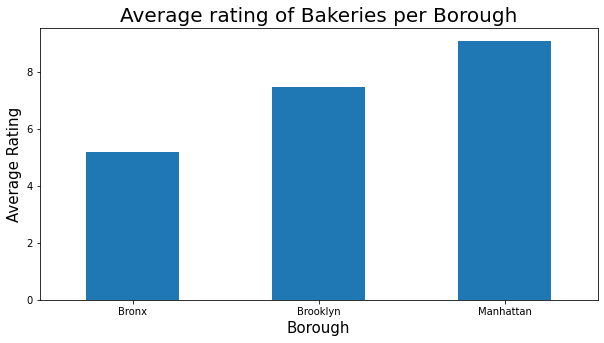

In [73]:
bakeries_stats.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of Bakeries per Borough', fontsize=20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [77]:
bakeries_stats=bakeries_neighborhood_stats[bakeries_neighborhood_stats['Average Rating']>=7.0]
bakeries_stats

,Neighborhood,Average Rating
1,Belmont,8.500000
2,Boerum Hill,8.100000
4,Brooklyn Heights,7.300000
6,Carroll Gardens,8.080000
7,Chinatown,9.100000
10,Concourse,7.200000
12,Downtown,7.500000
13,East Williamsburg,8.766667
15,Fort Hamilton,8.300000
16,Gravesend,7.500000


In [78]:
bakeries_neighborhood_stats=pd.merge(bakeries_neighborhood_stats,ny_data, on='Neighborhood')
bakeries_neighborhood_stats=bakeries_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
bakeries_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Bedford Park,40.870185,-73.885512,0.000000
1,Bronx,Belmont,40.857277,-73.888452,8.500000
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.100000
3,Brooklyn,Brighton Beach,40.576825,-73.965094,6.800000
4,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.300000
5,Brooklyn,Bushwick,40.698116,-73.925258,6.800000
6,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.080000
7,Manhattan,Chinatown,40.715618,-73.994279,9.100000
8,Brooklyn,City Line,40.678570,-73.867976,0.000000
9,Brooklyn,Cobble Hill,40.687920,-73.998561,6.500000


In [79]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the bakeries in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the bakeries and add each to the incidents feature group
for lat, lng, in bakeries_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [80]:
bakeries_neighborhood_stats['Label']=bakeries_neighborhood_stats['Neighborhood']+', '+bakeries_neighborhood_stats['Borough']+'('+bakeries_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in bakeries_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add bakeries to map
ny_map.add_child(incidents)